Mounted at /content/drive
Cargando datos...

--- Distribución de Datos Limpia ---
Total de muestras: 5224
Set de Entrenamiento: 3343 | Distribución: Counter({0: 3232, 1: 111})
Set de Validación:    836 | Distribución: Counter({0: 808, 1: 28})
Set de Prueba Final:  1045 | Distribución: Counter({0: 1010, 1: 35})
------------------------------------

Procesando datos (Solo fillna y escalado)...
Reducción de Outliers DESACTIVADA.
Transformada de Fourier DESACTIVADA.
Filtro/Suavizado DESACTIVADO.
Procesamiento completado.

Preparando tensores de Keras con datos originales...
Usando Focal Loss (gamma=2.0, alpha=0.25).

Iniciando entrenamiento con CNN SIMPLE + DATOS CRUDOS + FOCAL LOSS (Conservadora)...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 3197, 32)       │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 3197, 32)       │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 1065, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1065, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 34080)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │     1,090,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,090,978 (4.16 MB)

 Trainable params: 1,090,914 (4.16 MB)

 Non-trainable params: 64 (256.00 B)

Epoch 1/80
53/53 - 18s - 341ms/step - accuracy: 0.9330 - auc: 0.9551 - loss: 0.0270 - val_accuracy: 0.9665 - val_auc: 0.9694 - val_loss: 0.0367 - learning_rate: 1.0000e-04
Epoch 2/80
53/53 - 18s - 331ms/step - accuracy: 0.9569 - auc: 0.9684 - loss: 0.0185 - val_accuracy: 0.9665 - val_auc: 0.9679 - val_loss: 0.0332 - learning_rate: 1.0000e-04
Epoch 3/80
53/53 - 19s - 356ms/step - accuracy: 0.9575 - auc: 0.9669 - loss: 0.0168 - val_accuracy: 0.9665 - val_auc: 0.9673 - val_loss: 0.0301 - learning_rate: 1.0000e-04
Epoch 4/80
53/53 - 16s - 300ms/step - accuracy: 0.9656 - auc: 0.9685 - loss: 0.0166 - val_accuracy: 0.9641 - val_auc: 0.9694 - val_loss: 0.0327 - learning_rate: 1.0000e-04
Epoch 5/80
53/53 - 16s - 301ms/step - accuracy: 0.9548 - auc: 0.9659 - loss: 0.0171 - val_accuracy: 0.9665 - val_auc: 0.9680 - val_loss: 0.0216 - learning_rate: 1.0000e-04
Epoch 6/80
53/53 - 16s - 304ms/step - accuracy: 0.9635 - auc: 0.9707 - loss: 0.0154 - val_accuracy: 0.9665 - val_auc: 0.9884 - val_loss: 0.0

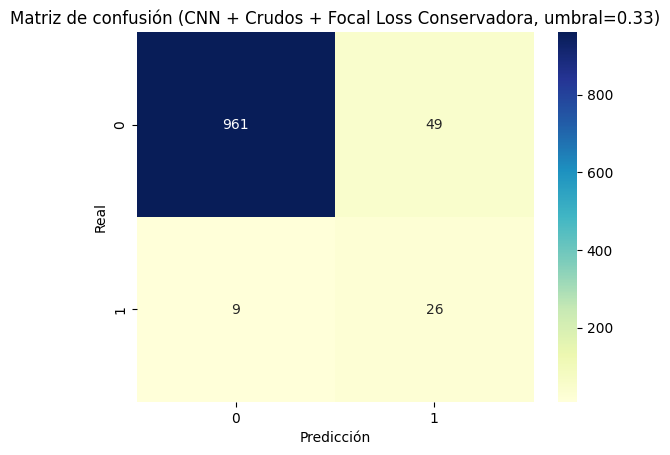

In [1]:
# ===============================================
# 🔭 DETECCIÓN DE EXOPLANETAS — CNN + Crudos + Focal Loss (Conservadora)
# ===============================================

# --- Importaciones ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from scipy import ndimage
from sklearn.preprocessing import StandardScaler
from scipy.ndimage import uniform_filter1d
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from collections import Counter
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, Flatten, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers
import tensorflow.keras.backend as K
import seaborn as sn
import warnings
warnings.filterwarnings("ignore")
from google.colab import drive
drive.mount('/content/drive')

# ===============================================
# 🔹 CARGA DE DATOS (CORREGIDA)
# ===============================================
print("Cargando datos...")
rutatrain = '/content/drive/MyDrive/datasets/exoplanetas_combinados_train.csv'
df = pd.read_csv(rutatrain)
df['LABEL'] = df['LABEL'].map({1: 0, 2: 1})

Y = df['LABEL'].copy()
X = df.drop(columns=['LABEL']).copy()

X_train_full, X_test, Y_train_full, Y_test = train_test_split(
    X, Y, test_size=0.20, random_state=42, stratify=Y
)
X_train, X_val, Y_train, Y_val = train_test_split(
    X_train_full, Y_train_full, test_size=0.20, random_state=42, stratify=Y_train_full
)

print("\n--- Distribución de Datos Limpia ---")
print(f"Total de muestras: {len(X)}")
print(f"Set de Entrenamiento: {len(X_train)} | Distribución: {Counter(Y_train)}")
print(f"Set de Validación:    {len(X_val)} | Distribución: {Counter(Y_val)}")
print(f"Set de Prueba Final:  {len(X_test)} | Distribución: {Counter(Y_test)}")
print("------------------------------------")


# ===============================================
# 🔹 FUNCIONES DE PROCESAMIENTO (Inutilizadas)
# ===============================================
def fourier_transform(df_numpy):
    arr = np.asarray(df_numpy)
    # ... (código de la función)
    return arr
def iterar_ruo(df, n=2, reduce_pct=0.01, half_width=4):
    df2 = df.copy()
    # ... (código de la función)
    return df2
def apply_filter(df, filternumber):
    arr = np.asarray(df)
    # ... (código de la función)
    return arr
# -----------------------------------------------

def apply_standardization(df_train, df_val, df_test):
    scaler = StandardScaler()
    norm_train = scaler.fit_transform(np.asarray(df_train))
    norm_val = scaler.transform(np.asarray(df_val))
    norm_test = scaler.transform(np.asarray(df_test))
    return pd.DataFrame(norm_train), pd.DataFrame(norm_val), pd.DataFrame(norm_test)

# ===============================================
# 🔹 PROCESAMIENTO (DATOS CRUDOS)
# ===============================================
print("\nProcesando datos (Solo fillna y escalado)...")
X_train = X_train.replace([np.inf, -np.inf], np.nan).fillna(0)
X_val = X_val.replace([np.inf, -np.inf], np.nan).fillna(0)
X_test = X_test.replace([np.inf, -np.inf], np.nan).fillna(0)

print("Reducción de Outliers DESACTIVADA.")
print("Transformada de Fourier DESACTIVADA.")
print("Filtro/Suavizado DESACTIVADO.")

X_train, X_val, X_test = apply_standardization(X_train, X_val, X_test)
print("Procesamiento completado.")

# ===============================================
# 🔹 PREPARACIÓN KERAS (SIN SMOTE)
# ===============================================
print("\nPreparando tensores de Keras con datos originales...")
X_train_model = np.expand_dims(np.asarray(X_train).astype(np.float32), axis=2)
X_val_model   = np.expand_dims(np.asarray(X_val).astype(np.float32), axis=2)
X_test_model  = np.expand_dims(np.asarray(X_test).astype(np.float32), axis=2)

Y_train_ohe = to_categorical(Y_train, num_classes=2)
Y_val_ohe   = to_categorical(Y_val, num_classes=2)

# ===============================================
# 🔹 FUNCIÓN: FOCAL LOSS (alpha=0.25 - CONSERVADORA)
# ===============================================
def categorical_focal_loss(gamma=2.0, alpha=0.25): # <-- CAMBIO A alpha=0.25
    """
    Implementación de Focal Loss para Keras.
    gamma: Enfoca el entrenamiento en los ejemplos difíciles.
    alpha=0.25 le da un peso de 3x a la clase 0 (mayoritaria) (0.75 / 0.25)
    """
    def focal_loss(y_true, y_pred):
        y_pred = K.clip(y_pred, K.epsilon(), 1.0 - K.epsilon())

        cross_entropy = -y_true * K.log(y_pred)

        loss = K.pow(1.0 - y_pred, gamma) * cross_entropy

        alpha_factor = y_true * K.expand_dims(alpha, 0) + (1.0 - y_true) * K.expand_dims(1.0 - alpha, 0)
        loss = alpha_factor * loss

        return K.mean(K.sum(loss, axis=-1))

    return focal_loss

# ===============================================
# 🔹 MODELO CNN (SIMPLE)
# ===============================================
def create_simple_cnn(X_samp, activation='relu'):
    timesteps = X_samp.shape[1]
    channels = X_samp.shape[2]

    model = Sequential([
        Conv1D(32, 5, padding='same', activation=activation,
               input_shape=(timesteps, channels)),
        BatchNormalization(),
        MaxPooling1D(3),
        Dropout(0.3),

        Flatten(),
        Dense(32, activation=activation),
        Dropout(0.4),

        Dense(2, activation='softmax')
    ])
    return model

# ===============================================
# 🔹 ENTRENAMIENTO (con Focal Loss Conservadora)
# ===============================================
print(f"Usando Focal Loss (gamma=2.0, alpha=0.25).") # <-- CAMBIO

LEARNING_RATE = 1e-4

print("\nIniciando entrenamiento con CNN SIMPLE + DATOS CRUDOS + FOCAL LOSS (Conservadora)...")
EPOCHS = 80
BATCH_SIZE = 64
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=1e-7)

model = create_simple_cnn(X_train_model)
model.summary()

# --- COMPILACIÓN CON FOCAL LOSS (NUEVA) ---
model.compile(optimizer=Adam(learning_rate=LEARNING_RATE),
              loss=categorical_focal_loss(gamma=2.0, alpha=0.25), # <-- CAMBIO
              metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])

history = model.fit(
    X_train_model, Y_train_ohe,
    validation_data=(X_val_model, Y_val_ohe),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    shuffle=True,
    callbacks=[early_stop, reduce_lr],
    verbose=2
)
print("Entrenamiento finalizado.")

# ===============================================
# 🔹 SELECCIÓN DE UMBRAL (Tu código, sobre validación)
# ===============================================
y_val_prob = model.predict(X_val_model)[:, 1]
best_thresh = 0.5
best_f1 = 0.0
for t in np.arange(0.15, 0.95, 0.01):
    y_val_pred = (y_val_prob >= t).astype(int)
    f1 = f1_score(Y_val, y_val_pred)
    if f1 > best_f1:
        best_f1 = f1
        best_thresh = t
print(f"\n🔸 Mejor umbral (F1 validación): {best_thresh:.2f} con F1={best_f1:.3f}")

# ===============================================
# 🔹 EVALUACIÓN FINAL EN TEST (CORREGIDO)
# ===============================================
y_test_prob = model.predict(X_test_model)[:, 1]
y_test_pred = (y_test_prob >= best_thresh).astype(int)

print("\n===== 📊 RESULTADOS EN TEST (Limpio) - CNN + DATOS CRUDOS (Conservadora) =====")
print(classification_report(Y_test, y_test_pred, digits=4))
matrix = confusion_matrix(Y_test, y_test_pred)
sn.heatmap(matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.title(f'Matriz de confusión (CNN + Crudos + Focal Loss Conservadora, umbral={best_thresh:.2f})')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.show()